#  EMF RBM Energy Densities

Look at different ways of computing the

- energy density
- free energy density
- entropy density

We can

- use the TAP S and MF Energy *U_naive   
    - which takes an equlibration step first  
    - S(mv, mh), U_naive(mv, mh)
- use a simple h = means_hiddens() step
    - S(v, h), E_MF(v, h)


In [42]:
import numpy as np
import h5py

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import linear_model, datasets, metrics, preprocessing 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

import psutil

In [43]:
from sklearn.datasets import fetch_mldata
from sklearn.utils.validation import assert_all_finite
from scipy.sparse import csc_matrix, csr_matrix, lil_matrix
from sklearn.preprocessing import Binarizer
np.seterr(all='warn')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'warn'}

In [44]:
hf =  h5py.File('mnist.h5','r')
print('List of arrays in this file: \n', hf.keys())
X = np.array(hf.get('HDF5.name___X'))
y = np.array(hf.get('HDF5.name___y'))

print X.shape, y.shape
hf.close()
np.linalg.norm(X, ord=2)

('List of arrays in this file: \n', [u'HDF5.name___X', u'HDF5.name___y'])
(60000, 784) (60000,)


2117.6342254841179

### Helper methods for simple case

In [12]:
from sklearn.utils.fixes import expit    
from sklearn.utils.extmath import safe_sparse_dot

def sig_means(x, b, W):
    a = safe_sparse_dot(x, W.T) + b
    return expit(a, out=a)

### Baseline

In [16]:
# %load emf_rbm.py

import time

import numpy as np
import scipy.sparse as sp


from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.externals.six.moves import xrange
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.utils import gen_even_slices
from sklearn.utils import issparse
from sklearn.utils.validation import check_is_fitted

from sklearn.utils.fixes import expit  # logistic function  
from sklearn.utils.extmath import safe_sparse_dot, log_logistic, softmax

class EMF_RBM(BaseEstimator, TransformerMixin):
    """Extended Mean Field Restricted Boltzmann Machine (RBM).
    A Restricted Boltzmann Machine with binary visible units and
    binary hidden units. Parameters are estimated using the Extended Mean
    Field model, based on the TAP equations
    Read more in the :ref:`User Guide <rbm>`.
    Parameters
    ----------
    n_components : int, optional
        Number of binary hidden units.
    learning_rate : float, optional
        The learning rate for weight updates. It is *highly* recommended
        to tune this hyper-parameter. Reasonable values are in the
        10**[0., -3.] range.
    batch_size : int, optional
        Number of examples per minibatch.
    momentum : float, optional
        gradient momentum parameter
    decay : float, optional
        decay for weight update regularizer
    weight_decay: string, optional []'L1', 'L2', None]
        weight update regularizer

    neq_steps: int, optional
        Number of equilibration steps
    n_iter : int, optional
        Number of iterations/sweeps over the training dataset to perform
        during training.
    sigma: float, optional
        variance of initial W weight matrix
    thresh: float, optional
        threshold for values in W weight matrix, vectors
    verbose : int, optional
        The verbosity level. The default, zero, means silent mode.
    random_state : integer or numpy.RandomState, optional
        A random number generator instance to define the state of the
        random permutations generator. If an integer is given, it fixes the
        seed. Defaults to the global numpy random number generator.
    Attributes
    ----------
    h_bias : array-like, shape (n_components,)
        Biases of the hidden units.
    v_bias : array-like, shape (n_features,)
        Biases of the visible units.
    W : array-like, shape (n_components, n_features)
        Weight matrix, where n_features in the number of
        visible units and n_components is the number of hidden units.
    Examples
    --------
    >>> import numpy as np
    >>> X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
    >>> model = EMF_RBM(n_components=2)
    >>> model.fit(X)
    EmfRBM(batch_size=10, learning_rate=0.1, n_components=2, n_iter=10,
           random_state=None, verbose=0)
    References
    ----------
    [1] Marylou Gabrie´, Eric W. Tramel1 and Florent Krzakala1, 
        Training Restricted Boltzmann Machines via the Thouless-Anderson-Palmer Free Energy
        https://arxiv.org/pdf/1506.02914
    """
    def __init__(self, n_components=256, learning_rate=0.005, batch_size=100, sigma=0.001, neq_steps = 3,
                 n_iter=20, verbose=0, random_state=None, momentum = 0.5, decay = 0.01, weight_decay='L1', thresh=1e-8, monitor=False):
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_iter = n_iter
        self.verbose = verbose

        self.momentum = momentum
        self.decay = decay
        self.weight_decay = weight_decay

        self.sigma = sigma
        self.neq_steps = neq_steps

        # learning rate / mini_batch
        self.lr = learning_rate

        # threshold for floats
        self.thresh = thresh

        # store in case we want to reset
        self.random_state = random_state
        

        # self.random_state_ = random_state
        # always start with new random state
        self.random_state = check_random_state(random_state)
        
        # h bias
        self.h_bias = np.zeros(self.n_components, )
        self.h_samples_ = np.zeros((self.batch_size, self.n_components))
        # moved to fit
        
        self.W = None
        self.dW_prev = None
        self.W2 = None
        self.v_bias = None
        
        # internal monitors: i would prefer callbacks
        self.monitor = monitor
        self.entropies = []
        self.free_energies = []
        self.mean_field_energies = []
        

    def init_weights(self, X):
        """ If the user specifies the training dataset, it can be useful to                                                                                   
        initialize the visibile biases according to the empirical expected                                                                                
        feature values of the training data.                                                                                                              

        TODO: Generalize this biasing. Currently, the biasing is only written for                                                                         
               the case of binary RBMs.
        """
        # 
        eps = self.thresh

        # Mean across  samples 
        if issparse(X):
            probVis = csr_matrix.mean(X, axis=0)
        else:
            probVis = np.mean(X,axis=0)            

        # safe for CSR / sparse mats ?
        # do we need it if we use softmax ?
        probVis[probVis < eps] = eps            # Some regularization (avoid Inf/NaN)  
        #probVis[probVis < (1.0-eps)] = (1.0-eps)   
        self.v_bias = np.log(probVis / (1.0-probVis)) # Biasing as the log-proportion
        
        # (does not work)
        # self.v_bias = softmax(probVis)
        
        # initialize arrays to 0
        self.W = np.asarray(
            self.random_state.normal(
                0,
                self.sigma,
                (self.n_components, X.shape[1])
            ),
            order='fortran')

        self.dW_prev = np.zeros_like(self.W)
        self.W2 = self.W*self.W
        return 0


    def sample_layer(self, layer):
        """Sample from the conditional distribution P(h|v) or P(v|h)"""
        self.random_state = check_random_state(self.random_state)
        sample = (self.random_state.random_sample(size=layer.shape) < layer) 
        return sample

    def _sample_hiddens(self, v):
        """Sample from the conditional distribution P(h|v).
        Parameters
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer to sample from.
        Returns
        -------
        h : array-like, shape (n_samples, n_components)
            Values of the hidden layer.
        """
        return self.sample_layer(self._mean_hiddens(v))

    def _mean_hiddens(self, v):
        """Computes the conditional probabilities P(h=1|v).
        Parameters
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        Returns
        -------
        h : array-like, shape (n_samples, n_components)
            Corresponding mean field values for the hidden layer.
        """
        p = safe_sparse_dot(v, self.W.T) + self.h_bias
        return expit(p, out=p)

    def _sample_visibles(self, h):
        """Sample from the distribution P(v|h).
        Parameters
        ----------
        h : array-like, shape (n_samples, n_components)
            Values of the hidden layer to sample from.
        Returns
        -------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        """
        return sample_layer(self._mean_visible(h))

    def _mean_visibles(self, h):
        """Computes the conditional probabilities P(v=1|h).
        Parameters
        ----------
        h : array-like, shape (n_samples, n_components)
            Corresponding mean field values for the hidden layer.
        Returns
        -------
         v : array-like, shape (n_samples, n_features)
            Values of the visible layer.     
        """
        #p = np.dot(h, self.W) + self.v_bias
        p = safe_sparse_dot(h, W) + self.v_bias
        return expit(p, out=p)

    def sigma_means(self, x, b, W):
        """helper class for computing Wx+b """
        a = safe_sparse_dot(x, W.T) + b
        return expit(a, out=a)

    def init_batch(self, vis):
        """initialize the batch for EMF only"""
        v_pos = vis
        v_init = v_pos

        h_pos = self._mean_hiddens(v_pos)
        h_init = h_pos

        return v_pos, h_pos, v_init, h_init

    def equilibrate(self, v0, h0, iters=3):
        """Run iters steps of the TAP fixed point equations"""
        mv = v0
        mh = h0
     
        for i in range(iters):
            mv = 0.5 *self.mv_update(mv, mh) + 0.5*mv
            mh = 0.5 *self.mh_update(mv, mh) + 0.5*mh
        return mv, mh

    def mv_update(self, v, h):  
        """update TAP visbile magnetizations, to second order"""
        
        # a = np.dot(h, self.W) + self.v_bias
        a = safe_sparse_dot(h, self.W) + self.v_bias

        h_fluc = h-np.multiply(h,h)
        #a += h_fluc.dot(self.W2)*(0.5-v)
        
        # 0.5-v is elementwise => dense
        if issparse(v):
            v_half = (0.5-v.todense())
        else:
             v_half = (0.5-v)
            
        a += np.multiply(safe_sparse_dot(h_fluc,self.W2), v_half)
        return expit(a, out=a)

    def mh_update(self, v, h):
        """update TAP hidden magnetizations, to second order"""
        a = safe_sparse_dot(v, self.W.T) + self.h_bias
 
        v_fluc = (v-(np.multiply(v,v)))
        #a += (v-v*v).dot((self.W2).T)*(0.5-h)
        
        if issparse(h):
            h_half = (0.5-h.to_dense())
        else:        
            h_half = (0.5-h)
            
        a += np.multiply(safe_sparse_dot(v_fluc,self.W2.T),h_half)

        return expit(a, out=a)


    def weight_gradient(self, v_pos, h_pos ,v_neg, h_neg):
        """compute weight gradient of the TAP Free Energy, to second order"""
        # naive  / mean field
        dW = safe_sparse_dot(v_pos.T, h_pos, dense_output=True).T - np.dot(h_neg.T, v_neg)
        
        # tap2 correction
        #  elementwise multiplies
        h_fluc = (h_neg - np.multiply(h_neg,h_neg)).T
        v_fluc = (v_neg - np.multiply(v_neg,v_neg))
        #  dW_tap2 = h_fluc.dot(v_fluc)*self.W
        dW_tap2 = np.multiply(safe_sparse_dot(h_fluc,v_fluc),self.W)

        dW -= dW_tap2
        return dW

    def score_samples(self, X):
        """Compute the pseudo-likelihood of X.
        Parameters
        ----------
        X : {array-like, sparse matrix} shape (n_samples, n_features)
            Values of the visible layer. Must be all-boolean (not checked).
        Returns
        -------
        pseudo_likelihood : array-like, shape (n_samples,)
            Value of the pseudo-likelihood (proxy for likelihood).
        Notes
        -----
        This method is not deterministic: it computes the TAP Free Energy on X,
        then on a randomly corrupted version of X, and
        returns the log of the logistic function of the difference.
        """
        check_is_fitted(self, "W")

        v = check_array(X, accept_sparse='csr')
        v, v_ = self._corrupt_data(v)       

        fe = self._free_energy(v)
        fe_ = self._free_energy(v_)
        return v.shape[1] * log_logistic(fe_ - fe)
    
    
    def score_samples_TAP(self, X):
        """Compute the pseudo-likelihood of X using second order TAP
        Parameters
        ----------
        X : {array-like, sparse matrix} shape (n_samples, n_features)
            Values of the visible layer. Must be all-boolean (not checked).
        Returns
        -------
        pseudo_likelihood : array-like, shape (n_samples,)
            Value of the pseudo-likelihood (proxy for likelihood).
        Notes
        -----
        This method is not deterministic: it computes the TAP Free Energy on X,
        then on a randomly corrupted version of X, and
        returns the log of the logistic function of the difference.
        """
        check_is_fitted(self, "W")

        v = check_array(X, accept_sparse='csr')      
        v, v_ = self._corrupt_data(v)       

        fe = self._free_energy_TAP(v)
        fe_ = self._free_energy_TAP(v_)
        return v.shape[1] * log_logistic(fe_ - fe)
    
    def _corrupt_data(self, v):
        self.random_state = check_random_state(self.random_state)
        """Randomly corrupt one feature in each sample in v."""
        ind = (np.arange(v.shape[0]),
               self.random_state.randint(0, v.shape[1], v.shape[0]))
        if issparse(v):
            data = -2 * v[ind] + 1
            v_ = v + sp.csr_matrix((data.A.ravel(), ind), shape=v.shape)
        else:
            v_ = v.copy()
            v_[ind] = 1 - v_[ind]
        return v, v_
    
    
    def score_samples_entropy(self, X):
        """Compute the entropy of X
        Parameters
        ----------
        X : {array-like, sparse matrix} shape (n_samples, n_features)
            Values of the visible layer. Must be all-boolean (not checked).
        Returns
        -------
        entropy : array-like, shape (n_samples,)
            Value of the entropy.
        Notes
        -----
        This method is not deterministic: it computes the entropy on X,
        then on a randomly corrupted version of X, and returns the difference.
        """
        check_is_fitted(self, "W")

        v = check_array(X, accept_sparse='csr')
        v, v_ = self._corrupt_data(v)       

        s = self._entropy(v)
        s_ = self._entropy(v_)
        return v.shape[1] * (s_ - s)

    
        #TODO: run per column
    def _denoise(self, m, eps=1.0e-8):
        """denoise magnetization"""
        m = np.maximum(m,eps)
        m = np.minimum(m,1.0-eps)
        return m


    def _U_naive_TAP(self, v):
        """Computes the  Mean Field TAP Energy E(v) 
        Parameters. This is also U_Naive in the TAP FE
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        Returns
        -------
        U_naive : array-like, shape (n_samples,)
            The value of the mean field component of the TAP free energy.
        """
        h = self._mean_hiddens(v)
        mv, mh = self.equilibrate(v, h, iters=self.neq_steps)
           
        mv = self._denoise(mv)
        mh = self._denoise(mh)
    
        # sum over nodes: axis=1
        
        U_naive = (-safe_sparse_dot(mv, self.v_bias) 
                    -safe_sparse_dot(mh, self.h_bias) 
                        -(mv.dot(self.W.T)*(mh)).sum(axis=1))         

        return U_naive
            
    def _free_energy_TAP(self, v):
        """Computes the TAP Free Energy F(v) to second order Parameters
        Also provides  values of components (energy, naive, Onsager term)
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        Returns
        -------
        free_energy : array-like, shape (n_samples,)
            The value of the free energy.
        """
        #fe = (- safe_sparse_dot(v, self.v_bias)
        #        - np.logaddexp(0, safe_sparse_dot(v, self.W.T)
        #                       + self.h_bias).sum(axis=1))
        
        v = check_array(X, accept_sparse='csr')      
            
        h = self._mean_hiddens(v)
        mv, mh = self.equilibrate(v, h, iters=self.neq_steps)
           
        mv = self._denoise(mv)
        mh = self._denoise(mh)
    
        # sum over nodes: axis=1
        
        U_naive = (-safe_sparse_dot(mv, self.v_bias) 
                    -safe_sparse_dot(mh, self.h_bias) 
                        -(mv.dot(self.W.T)*(mh)).sum(axis=1))

        Entropy = ( -(mv*np.log(mv)+(1.0-mv)*np.log(1.0-mv)).sum(axis=1)  
                    -(mh*np.log(mh)+(1.0-mh)*np.log(1.0-mh)).sum(axis=1) )
           
        h_fluc = (mh - (mh*mh))
        v_fluc = (mv - (mv*mv))

        # if we do it this way, we need to normalize by 1/batch_size 
        # which we need to obtain from the W2 matrix
        # (I think because of the double sum)
        # this is not obvious in the paper...have to be very careful here...too damn slow
        #tap_norm = 1.0/float(mv.shape[0])
        #dW_tap2 = h_fluc.dot(self.W2).dot(v_fluc.T)
        # Onsager = (-0.5*dW_tap2).sum(axis=1)*tap_norm
            
        # julia way, does not require extra norm, but maybe slower ?
        dW_tap2 = h_fluc.dot(self.W2)*v_fluc
        Onsager = (-0.5*dW_tap2).sum(axis=1)
        fe_tap = U_naive + Onsager - Entropy

        return fe_tap, Entropy, U_naive, Onsager


    
    def _free_energy(self, v):
        """Computes the RBM Free Energy F(v) Parameters.  
        (No mean field h values necessary)
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        Returns
        -------
        free_energy : array-like, shape (n_samples,)
            The value of the free energy.
        """
        fe = (- safe_sparse_dot(v, self.v_bias)
                - np.logaddexp(0, safe_sparse_dot(v, self.W.T)
                               + self.h_bias).sum(axis=1) )

        return fe 
            

    def _entropy(self, v):
        """Computes the TAP Entropy (S) , from an equilibration step
        Parameters
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        Returns
        -------
        entropy : array-like, shape (n_samples,)
            The value of the entropy.
        """
         
        h = self._mean_hiddens(v)
        mv, mh = self.equilibrate(v, h, iters=self.neq_steps)

        mv = self._denoise(mv)
        mh = self._denoise(mh)

        # appears to be wrong ?  unsure why ?  maybe because it is not denoised !!!
        Entropy = ( -(mv*np.log(mv)+(1.0-mv)*np.log(1.0-mv)).sum(axis=1)  
                    -(mh*np.log(mh)+(1.0-mh)*np.log(1.0-mh)).sum(axis=1)  )
                         
        return Entropy


    
    def _free_energy(self, v):
        """Computes the RBM Free Energy F(v) 
        Parameters
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        Returns
        -------
        free_energy : array-like, shape (n_samples,)
            The value of the free energy.
        """
        fe = (- safe_sparse_dot(v, self.v_bias)
                - np.logaddexp(0, safe_sparse_dot(v, self.W.T)
                               + self.h_bias).sum(axis=1) )

        return fe 

    
    def partial_fit(self, X, y=None):
        """Fit the model to the data X which should contain a partial
        segment of the data.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.
        Returns
        -------
        self : EMF_RBM
            The fitted model.
        """
        X = check_array(X, accept_sparse='csr', dtype=np.float64)
        if not hasattr(self, 'random_state_'):
            self.random_state_ = check_random_state(self.random_state)
        if not hasattr(self, 'W'):
            self.W = np.asarray(
                self.random_state_.normal(
                    0,
                    0.01,
                    (self.n_components, X.shape[1])
                ),
                order='F')
        if not hasattr(self, 'h_bias'):
            self.h_bias = np.zeros(self.n_components, )
        if not hasattr(self, 'v_bias'):
            self.v_bias = np.zeros(X.shape[1], )

        # not used ?
        #if not hasattr(self, 'h_samples_'):
        #    self.h_samples_ = np.zeros((self.batch_size, self.n_components))

        self._fit(X)

    def _fit(self, v_pos):
        """Inner fit for one mini-batch.
        Adjust the parameters to maximize the likelihood of v using
        Extended Mean Field theory (second order TAP equations).
        Parameters
        ----------
        v_pos : array-like, shape (n_samples, n_features)
            The data to use for training.
        """
        X_batch = v_pos
        lr = float(self.learning_rate) / X_batch.shape[0]
        decay = self.decay

        v_pos, h_pos, v_init, h_init = self.init_batch(X_batch)
              
        a = safe_sparse_dot(h_init, self.W, dense_output=True) + self.v_bias
        a = expit(a, out=a)

        # get_negative_samples
        v_neg, h_neg = self.equilibrate(v_init, h_init, iters=self.neq_steps) 
        
        # basic gradient
        dW = self.weight_gradient(v_pos, h_pos ,v_neg, h_neg) 

        # regularization based on weight decay
        #  similar to momentum >
        if self.weight_decay == "L1":
            dW -= decay * np.sign(self.W)
        elif self.weight_decay == "L2":
            dW -= decay * self.W

        # can we use BLAS here ?
        # momentum
        # note:  what do we do if lr changes per step ? not ready yet
        dW += self.momentum * self.dW_prev  
        # update
        self.W += lr * dW 

        # storage for next iteration

        # is this is a memory killer 
        self.dW_prev =  dW  
        
        # is this wasteful...can we avoid storing 2X the W mat ?
        # elementwise multiply
        self.W2 = np.multiply(self.W,self.W)

        # update bias terms
        #   csr matrix sum is screwy, returns [[1,self.n_components]] 2-d array  
        #   so I always use np.asarray(X.sum(axis=0)).squeeze()
        #   although (I think) this could be optimized
        self.v_bias += lr * (np.asarray(v_pos.sum(axis=0)).squeeze() - np.asarray(v_neg.sum(axis=0)).squeeze())
        self.h_bias += lr * (np.asarray(h_pos.sum(axis=0)).squeeze() - np.asarray(h_neg.sum(axis=0)).squeeze())

        return 0

    
   
    
        
            
    def fit(self, X, y=None):
        """Fit the model to the data X.
        Parameters
        ----------
        X : {array-like, sparse matrix} shape (n_samples, n_features)
            Training data.
        Returns
        -------
        self : EMF_RBM
            The fitted model.
        """
        verbose = self.verbose
        monitor = self.monitor
        X = check_array(X, accept_sparse='csr', dtype=np.float64)
        self.random_state = check_random_state(self.random_state)
        
        self.init_weights(X)
        
        n_samples = X.shape[0]
        n_batches = int(np.ceil(float(n_samples) / self.batch_size))
        

        batch_slices = list(gen_even_slices(n_batches * self.batch_size,
                                            n_batches, n_samples))
        
        begin = time.time()
        for iteration in xrange(1, self.n_iter + 1):
            
            for batch_slice in batch_slices:
                self._fit(X[batch_slice])

            if verbose:
                end = time.time()
                print("[%s] Iteration %d, pseudo-likelihood = %.2f,"
                      " time = %.2fs"
                      % (type(self).__name__, iteration,
                         self.score_samples(X).mean(), end - begin))
                begin = end
                
            if monitor:
                print "computing TAP Free Energies"
                fe, s, u, o = self._free_energy_TAP(X)
                self.free_energies.append(np.mean(fe))
                self.entropies.append(np.mean(s))
                self.mean_field_energies.append(np.mean(u))
                print "monitor: ", np.mean(fe),  np.mean(s), np.mean(u)
            
        return self
    
    
    def transform(self, X):
        """Compute the hidden layer activation probabilities, P(h=1|v=X).
        Parameters
        ----------
        X : {array-like, sparse matrix} shape (n_samples, n_features)
            The data to be transformed.
        Returns
        -------
        h : array, shape (n_samples, n_components)
            Latent representations of the data.
        """
        check_is_fitted(self, "W")

        X = check_array(X, accept_sparse='csr', dtype=np.float64)
        return self._mean_hiddens(X)
    
    

In [17]:
psutil.swap_memory()

sswap(total=2147483648L, used=816840704L, free=1330642944L, percent=38.0, sin=14690766848L, sout=78417920L)

In [19]:
emf_rbm = EMF_RBM(verbose=True)
emf_rbm.fit(X)

KeyboardInterrupt: 

In [ ]:
### Mean field TAP Energies

Not exactly Gaussian

In [7]:
ids = np.random.choice(X.shape[0], size=6000)

In [20]:
U = emf_rbm._U_naive_TAP(X[ids])

In [34]:
U.shape

(6000,)

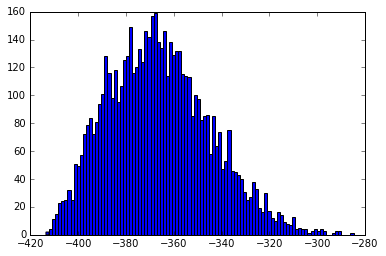

In [21]:
plt.hist(U,100);

### Plain Mean field Energies


In [6]:
p = sig_means(X[ids],emf_rbm.h_bias,emf_rbm.W)

NameError: name 'ids' is not defined

In [32]:
Emf = safe_sparse_dot(p, emf_rbm.h_bias) + safe_sparse_dot(X[ids], emf_rbm.v_bias)  + (X[ids].dot(emf_rbm.W.T)*p).sum(axis=1)

In [33]:
Emf.shape

(6000,)

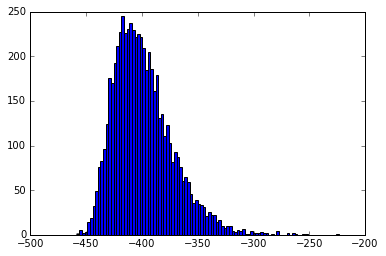

In [37]:
plt.hist(-Emf,100);

These are clearly NOT Guassian distributions, and I have a feeling that these are ground state energies, and subject to EVS, not the REM.  And that the REM has to be determined by looking at all Energies during all training steps

### All energies from all steps

Lets compute as many energies as we can and see what we get

(very very slow)
(took this out of code but left in the notebook for now)

In [ ]:
emf_rbm = EMF_RBM(verbose=True)
emf_rbm, U_energies = emf_rbm.fit_wEs(X)

In [27]:
Emf = U_energies[1]
len(Emf)
import itertools
merged = list(itertools.chain.from_iterable(Emf))

20

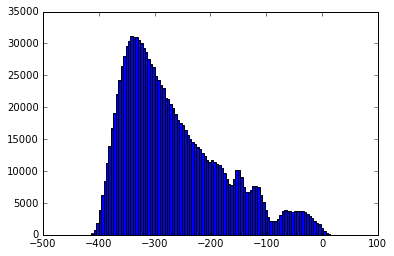

In [33]:
plt.hist(merged,100);
plt.title("all energies, for all data, for all iterations")

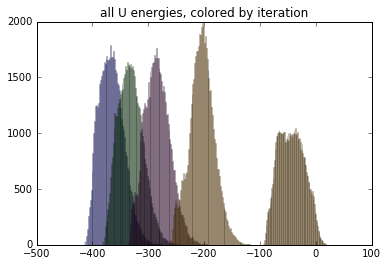

In [43]:
plt.hist(Emf[19],100, alpha=0.25);
plt.hist(Emf[14],100, alpha=0.25, color='green');
plt.hist(Emf[9],100, alpha=0.25, color='purple');
plt.hist(Emf[4],100, alpha=0.25, color='orange');
plt.hist(Emf[0],100, alpha=0.25, color='orange');

plt.title("all U energies, colored by iteration")

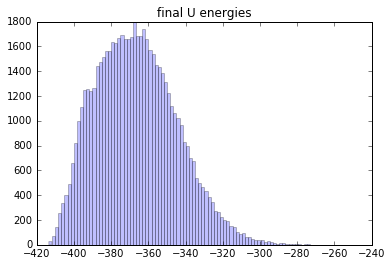

In [44]:
plt.hist(Emf[19],100, alpha=0.25);
plt.title("final U energies")

So ... what is the best interepretation ?

### Lets look at the mean Entropy, Energy, and Free Energy

In [21]:
emf_rbm = EMF_RBM(verbose=True, monitor=True)
emf_rbm= emf_rbm.fit(X)

[EMF_RBM] Iteration 1, pseudo-likelihood = -185.52, time = 11.40s
computing TAP Free Energies
monitor:  -376.888019949 329.945038695 -45.7310725495
[EMF_RBM] Iteration 2, pseudo-likelihood = -150.92, time = 34.14s
computing TAP Free Energies
monitor:  -378.115178774 256.746671683 -119.097812727
[EMF_RBM] Iteration 3, pseudo-likelihood = -133.64, time = 34.35s
computing TAP Free Energies
monitor:  -385.061269881 230.009324625 -152.10183052
[EMF_RBM] Iteration 4, pseudo-likelihood = -123.66, time = 31.08s
computing TAP Free Energies
monitor:  -397.256013669 212.957015039 -180.702914705
[EMF_RBM] Iteration 5, pseudo-likelihood = -116.87, time = 32.58s
computing TAP Free Energies
monitor:  -408.93642989 200.732704952 -204.039922251
[EMF_RBM] Iteration 6, pseudo-likelihood = -107.72, time = 30.04s
computing TAP Free Energies
monitor:  -420.200693103 191.037932703 -224.535057604
[EMF_RBM] Iteration 7, pseudo-likelihood = -103.88, time = 30.56s
computing TAP Free Energies
monitor:  -430.23488

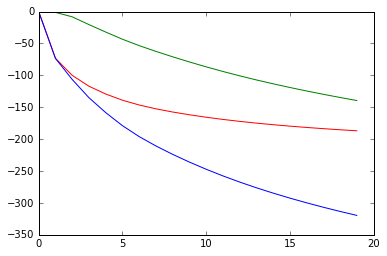

In [31]:
plt.plot(emf_rbm.entropies-emf_rbm.entropies[0], color='red')
plt.plot(emf_rbm.mean_field_energies-emf_rbm.mean_field_energies[0], color='blue')
plt.plot(emf_rbm.free_energies-emf_rbm.free_energies[0], color='green')

### Random Data

In [46]:
noise = np.random.normal(size=X.shape)

In [50]:
N = X+noise;

In [60]:
from matplotlib import pyplot
import matplotlib as mpl
%matplotlib inline  

def show_image(image): 
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

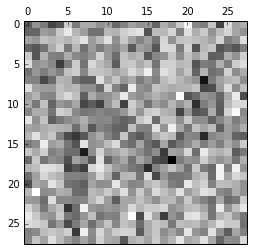

In [62]:
v = N[0,:]
show_image(np.reshape(v,[28,28]))

###  not really binarized but it should be

In [63]:
emf_rbm = EMF_RBM(verbose=True, monitor=True)
emf_rbm= emf_rbm.fit(N)

[EMF_RBM] Iteration 1, pseudo-likelihood = -1980.27, time = 11.16s
computing TAP Free Energies
monitor:  -377.359357581 305.652658909 -70.0570523317
[EMF_RBM] Iteration 2, pseudo-likelihood = -2219.40, time = 35.98s
computing TAP Free Energies
monitor:  -402.762933003 236.758465269 -163.146795496
[EMF_RBM] Iteration 3, pseudo-likelihood = -2498.05, time = 35.88s
computing TAP Free Energies
monitor:  -434.734835692 210.376691862 -220.266705245
[EMF_RBM] Iteration 4, pseudo-likelihood = -2909.75, time = 41.71s
computing TAP Free Energies
monitor:  -466.642612627 195.677534478 -265.471107268
[EMF_RBM] Iteration 5, pseudo-likelihood = -3314.64, time = 43.84s
computing TAP Free Energies
monitor:  -495.368288053 186.980345184 -301.447309979
[EMF_RBM] Iteration 6, pseudo-likelihood = -3938.24, time = 42.80s
computing TAP Free Energies
monitor:  -515.996971075 183.452643254 -324.026809717
[EMF_RBM] Iteration 7, pseudo-likelihood = -4470.43, time = 40.25s
computing TAP Free Energies
monitor:  -

/Users/charlesmartin14/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:250: RuntimeWarning: underflow encountered in multiply


[EMF_RBM] Iteration 12, pseudo-likelihood = -8468.59, time = 41.46s
computing TAP Free Energies
monitor:  -606.30781453 177.380636687 -409.996736663
[EMF_RBM] Iteration 13, pseudo-likelihood = -8993.09, time = 40.18s
computing TAP Free Energies


/Users/charlesmartin14/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:276: RuntimeWarning: underflow encountered in multiply


monitor:  -619.822086343 176.774473242 -422.229254685
[EMF_RBM] Iteration 14, pseudo-likelihood = -9606.21, time = 38.68s
computing TAP Free Energies
monitor:  -632.651850395 176.385565422 -433.44624788
[EMF_RBM] Iteration 15, pseudo-likelihood = -10983.40, time = 39.90s
computing TAP Free Energies
monitor:  -644.624855847 176.183215718 -443.453804312
[EMF_RBM] Iteration 16, pseudo-likelihood = -11513.48, time = 42.12s
computing TAP Free Energies
monitor:  -655.299627814 176.350332208 -450.462273585
[EMF_RBM] Iteration 17, pseudo-likelihood = -12176.75, time = 38.53s
computing TAP Free Energies
monitor:  -653.351190567 177.586507615 -420.167571797
[EMF_RBM] Iteration 18, pseudo-likelihood = -13281.04, time = 38.54s
computing TAP Free Energies
monitor:  -627.032102675 182.114452639 -310.560782571
[EMF_RBM] Iteration 19, pseudo-likelihood = -13821.81, time = 37.95s
computing TAP Free Energies
monitor:  -598.114641803 187.945866534 -182.964909836
[EMF_RBM] Iteration 20, pseudo-likelihood 

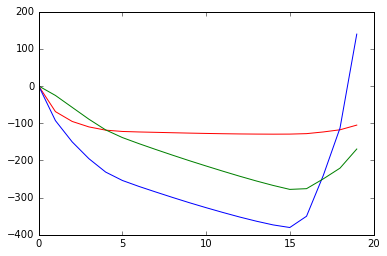

In [64]:
plt.plot(emf_rbm.entropies-emf_rbm.entropies[0], color='red')
plt.plot(emf_rbm.mean_field_energies-emf_rbm.mean_field_energies[0], color='blue')
plt.plot(emf_rbm.free_energies-emf_rbm.free_energies[0], color='green')